# HW6

# II. Analyzing Data

In [1]:
import pandas as pd
import numpy as np
pd.options.display.float_format = "{:,.4f}".format

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from scipy.stats import norm
from sklearn.linear_model import LinearRegression
from arch import arch_model

import warnings
warnings.filterwarnings("ignore")

import importlib
import utils as ut
importlib.reload(ut)

<module 'utils' from '/Users/chuan/github/0_Quantitative_Portfolio_Manager/homework/utils.py'>

# 2. Investigating Momentum

In this section, we empirically investigate some concerns regarding AQR's new momentum product.
On Canvas, find the data file, "**momentum_data.xlsx**".
- The first tab contains the momentum factor as an excess return: $\tilde{r}^{\mathrm{mom}}$.
- The second tab contains returns on portfolios corresponding to scored momentum deciles.
  - $r^{\operatorname{mom}(1)}$ denotes the portfolio of stocks in the lowest momentum decile, the "losers" with the lowest past returns.
  - $r^{\operatorname{mom}(10)}$ denotes the portfolio of stocks in the highest momentum decile.
- The third tab gives portfolios sorted by momentum and size.
  - $r^{\text {momsu }}$ denotes the portfolio of small stocks in the top 3 deciles of momentum scores.
  - $r^{\text {momBD }}$ denotes the portfolio of big-stocks in the bottom 3 deciles of momentum scores.

Note that the Fama-French momentum return, $\tilde{r}^{\mathrm{mom}: \mathrm{FF}}$, given in the first tab, is constructed by $\mathrm{FF}$ as,

$$
\tilde{r}^{\mathrm{mom}: \mathrm{FF}}=\frac{1}{2}\left(r^{\mathrm{momBU}}+r^{\mathrm{momSU}}\right)-\frac{1}{2}\left(r^{\mathrm{momBD}}+r^{\mathrm{momSD}}\right)
$$

In [2]:
file_path = './../data/momentum_data.xlsx'

descriptions = pd.read_excel(file_path) # first sheet
descriptions.set_index(descriptions.columns[0], inplace=True)
descriptions.index.name = 'Symbol'
display(descriptions)

factors = pd.read_excel(file_path, sheet_name='factors (excess returns)').set_index('Date')
display(factors)

momentum = pd.read_excel(file_path, sheet_name='momentum (excess returns)').set_index('Date')
display(momentum)

deciles = pd.read_excel(file_path, sheet_name='deciles (total returns)').set_index('Date')
display(deciles)

size_sorts = pd.read_excel(file_path, sheet_name='size_sorts (total returns)').set_index('Date')
display(size_sorts)

risk_free_rate = pd.read_excel(file_path, sheet_name='risk-free rate').set_index('Date')
display(risk_free_rate)

,Name,Unit,Construction,Description
Symbol,,,,
MKT,Market,Excess Return,Market-cap-weighted,US Equities
SMB,Size,Excess Return,Small Minus Big,Long small stocks and short big stocks
HML,Value,Excess Return,High Minus Low,Long value (high book-to-market) stocks and sh...
RF,Risk-free rate,Total Return,Tbills,NaN
SMALL LoPRIOR,Small Down,Total Return,Small Losers,Bottom 3 deciles and Small
SMALL HiPRIOR,Small Up,Total Return,Small Winners,Top 3 deciles and Small
BIG LoPRIOR,Big Down,Total Return,Big Losers,Bottom 3 deciles and Big
BIG HiPRIOR,Big Up,Total Return,Big Winners,Top 3 deciles and Big


,MKT,SMB,HML
Date,,,
1927-01-31,-0.0006,-0.0037,0.0454
1927-02-28,0.0418,0.0004,0.0294
1927-03-31,0.0013,-0.0165,-0.0261
1927-04-30,0.0046,0.0030,0.0081
1927-05-31,0.0544,0.0153,0.0473
...,...,...,...
2023-03-31,0.0251,-0.0551,-0.0885
2023-04-30,0.0061,-0.0335,-0.0004
2023-05-31,0.0035,0.0161,-0.0772


,UMD
Date,
1927-01-31,0.0036
1927-02-28,-0.0214
1927-03-31,0.0361
1927-04-30,0.0430
1927-05-31,0.0300
...,...
2023-03-31,-0.0249
2023-04-30,0.0163
2023-05-31,-0.0063


,Lo PRIOR,PRIOR 2,PRIOR 3,PRIOR 4,PRIOR 5,PRIOR 6,PRIOR 7,PRIOR 8,PRIOR 9,Hi PRIOR
Date,,,,,,,,,,
1927-01-31,-0.0332,-0.0446,0.0269,-0.0033,-0.0041,0.0097,0.0074,0.0036,-0.0041,-0.0024
1927-02-28,0.0753,0.0593,0.0825,0.0727,0.0322,0.0421,0.0283,0.0326,0.0420,0.0701
1927-03-31,-0.0323,-0.0301,-0.0392,-0.0477,-0.0048,-0.0242,0.0205,0.0041,0.0096,0.0547
1927-04-30,0.0204,-0.0320,-0.0247,-0.0137,0.0220,-0.0005,0.0205,-0.0059,0.0159,0.0549
1927-05-31,0.0272,0.0457,0.0595,0.0318,0.0636,0.0580,0.0496,0.0681,0.0811,0.0632
...,...,...,...,...,...,...,...,...,...,...
2023-03-31,-0.0261,0.0835,0.0658,0.0309,0.0069,0.0158,0.0149,0.0110,0.0017,0.0037
2023-04-30,-0.0669,0.0063,0.0324,0.0145,0.0043,0.0121,0.0097,0.0236,0.0069,0.0192
2023-05-31,0.0421,0.0696,0.0299,-0.0033,-0.0298,0.0116,-0.0225,0.0247,-0.0289,0.0842


,SMALL LoPRIOR,ME1 PRIOR2,SMALL HiPRIOR,BIG LoPRIOR,ME2 PRIOR2,BIG HiPRIOR
Date,,,,,,
1927-01-31,0.0008,0.0357,0.0040,-0.0040,0.0026,0.0000
1927-02-28,0.0701,0.0648,0.0551,0.0727,0.0380,0.0447
1927-03-31,-0.0346,-0.0288,-0.0206,-0.0357,-0.0018,0.0226
1927-04-30,-0.0075,-0.0048,0.0332,-0.0272,0.0075,0.0181
1927-05-31,0.0248,0.1115,0.0683,0.0552,0.0496,0.0718
...,...,...,...,...,...,...
2023-03-31,-0.0631,-0.0513,-0.0458,0.0764,0.0215,0.0093
2023-04-30,-0.0302,-0.0259,-0.0145,0.0042,0.0124,0.0212
2023-05-31,-0.0043,-0.0224,0.0082,0.0502,-0.0073,0.0251


,RF
Date,
1927-01-31,0.0025
1927-02-28,0.0026
1927-03-31,0.0030
1927-04-30,0.0025
1927-05-31,0.0030
...,...
2023-03-31,0.0036
2023-04-30,0.0035
2023-05-31,0.0036


## 2.1 Is Momentum sill profitable?

The excess returns of lucrative trading strategies often disappear once the strategy is well-known. The first widely-cited paper on momentum was published in 1993. Have momentum returns or risk changed since then? The AQR case takes place at the end of 2008. Have momentum returns changed in 2009-2023?

Investigate by filling out the summary statistics below for the full-sample and three sub-samples.

### (a) Using the data provided, fill in Table 1 with the appropriate stats for $\tilde{r}^{\text {mom:FF }}$.

$$
\begin{equation*}
\begin{aligned}
&\text { Table 2: Long-only momentum performance. }\\
&\begin{array}{llllll}
\hline \hline \text { Subsample } \quad \text { mean } \quad \text { vol } & \text { Sharpe } & \text { skewness } & \text { corr. to } \tilde{r}^m & \text { corr. to } \tilde{r}^v \\
\hline \hline & & & & \\
1927-2023 & & & \\
1927-1993 & & & \\
2009-2023 & & & \\
\hline \hline
\end{array}
\end{aligned}
\end{equation*}
$$

In [3]:
agg_years = [(1927, 2022), (1927, 1993), (1994, 2008), (2009, 2023)]
all_stats = [
    ut.summary_statistics_annualized(momentum.loc[f'{start}':f'{end}'])[['Mean', 'Vol', 'Sharpe', 'Skewness']]
    .assign(Period=f'{start}-{end}')
    .reset_index()
    .rename(columns={'index': 'Factor'})
    .set_index(['Period', 'Factor'])
    .assign(
        Corr_to_MKT=momentum.loc[f'{start}':f'{end}']
        .join(factors['MKT'].loc[f'{start}':f'{end}'])
        .corr()
        .loc['UMD', 'MKT'],
        Corr_to_HML=momentum.loc[f'{start}':f'{end}']
        .join(factors['HML'].loc[f'{start}':f'{end}'])
        .corr()
        .loc['UMD', 'HML']
    )
    for start, end in agg_years
]

result = pd.concat(all_stats)
result

,,Mean,Vol,Sharpe,Skewness,Corr_to_MKT,Corr_to_HML
Period,Factor,,,,,,
1927-2022,UMD,0.0777,0.1625,0.4782,-3.0154,-0.3444,-0.4149
1927-1993,UMD,0.0901,0.1600,0.5632,-3.8090,-0.3625,-0.4950
1994-2008,UMD,0.1044,0.1756,0.5945,-0.5820,-0.2345,-0.1294
2009-2023,UMD,-0.0260,0.1616,-0.1611,-2.6983,-0.3855,-0.3094


### (b) Has momentum changed much over time, as seen through these subsample statistics?

It doesn't change much in the most of the periods. But the momentum is showing negative return after 2009.

### (c) Does this data support AQR's argument that momentum is an important piece of the ideal portfolio? What if mean returns to momentum are in actuality near zero due to transaction costs - would there still be evidence here that momentum is valuable?

Yes, It was definitely profitable at 2008 when AQR was considering to launch the momentum product. Also, the momentum has a low correlation with market and value factor, which makes it a good diversifier. Even if the mean return is near zero, the momentum is still valuable because of its low correlation with other factors.

## 2.2. Whether a long-only implementation of momentum is valuable.

Construct your own long-only implementation:

$$\tilde{r}^{momU:FF} = \frac{1}{2} (\tilde{r}^{momBU} + \tilde{r}^{momSU}) − r^f $$

Note that this is following the FF approach of treating big and small stocks separately. This would be very similar to a scaled version of,

$$\tilde{r}^{momU} = \frac{1}{3} (\tilde{r}^{mom(8)} + \tilde{r}^{mom(9)} + \tilde{r}^{mom(10)}) − r^f $$


For the question below, use the FF-style $\tilde{r}^{momU:FF}_t$


### (a) Fill out Table 2 for the data in the period 1994-2022.

$$
\begin{equation*}
\begin{aligned}
&\text { Table 2: Long-only momentum performance. }\\
&\begin{array}{llllll}
\hline \hline \text { 1994-2023 } & \text { mean } \quad \text { vol } & \text { Sharpe } & \text { skew } & \text { corr. to } \tilde{r}^m & \text { corr. to } \tilde{r}^v \\
\hline \hline \text { Long-and-short, }\left(\tilde{r}^{\text {mom:FF }}\right) & & & \\
\text { Long-only }\left(\tilde{r}^{\text {momU:FF }}\right) & & & \\
\hline \hline
\end{array}
\end{aligned}
\end{equation*}
$$

In [4]:
mom_names = [('Long and Short', 'Long Only')]
mom = momentum.copy().rename(columns={'UMD': 'Long and Short'})
mom['Long Only'] = (size_sorts[['BIG HiPRIOR', 'SMALL HiPRIOR']].mean(axis=1)) - risk_free_rate['RF']
correlations = mom.join(factors[['MKT', 'HML']]).corr()

all_stats = (ut.summary_statistics_annualized(mom)[['Mean', 'Vol', 'Sharpe', 'Skewness']]
             .reset_index()
             .rename(columns={'index': 'Factor'})
             .set_index(['Factor']))
all_stats['Corr_to_MKT'] = all_stats.index.map(lambda factor: correlations.loc[factor, 'MKT'])
all_stats['Corr_to_HML'] = all_stats.index.map(lambda factor: correlations.loc[factor, 'HML'])
all_stats

,Mean,Vol,Sharpe,Skewness,Corr_to_MKT,Corr_to_HML
Factor,,,,,,
Long and Short,0.0748,0.1631,0.4586,-2.9921,-0.3463,-0.4048
Long Only,0.1351,0.2128,0.6346,-0.0156,0.9357,0.2105


### (b)  Is long-only momentum as attractive as long-short momentum with respect to mean, volatil-ity, and Sharpe Ratio?

Yes, long-only looks even more attractive than long-short momentum. The mean return is higher, while the volatility is similar. Sharpe ratio is higher as well.

### (c) Is long-only momentum as diversifying as long-short momentum with respect to market and value premia?


No, the long-only momentum portfolio has 93.6% of correlation with market, whereas the long-short momentum portfolio has -34% of correlation with market. This is because the long-only momentum portfolio is still exposed to market risk.

### (d) Show a plot of the cumulative product of $1+\tilde{r}^{\text {mom:FF }}$ and $1+\tilde{r}^{\text {momU:FF }}$ over the 1994-2023 subsample. $^2$

<Axes: xlabel='Date'>

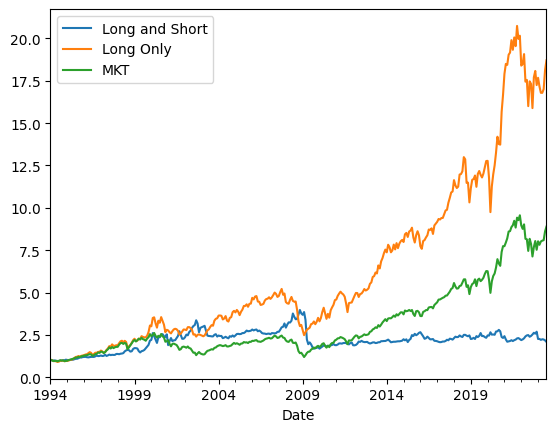

In [5]:
(1 + mom.join(factors['MKT'])).loc['1994':].cumprod().plot()

## 2.3. Is momentum just data mining, or is it a robust strategy?

Assess how sensitive the threshold for the “winners” and “losers” is in the results. Specifically, we compare three constructions:

- long the top 1 decile and short the bottom 1 deciles:

$$ \tilde{r}^{momD1} = r^{mom(10)} - r^{mom(1)}$$

- long the top 3 deciles and short the bottom 3 deciles:


$$ 
\begin{aligned}
\tilde{r}^{momD3} &= \frac{1}{3}(r^{mom(8)} + r^{mom(9)} + r^{mom(10)}) - \frac{1}{3} (r^{mom(3)} + r^{mom(2)} + r^{mom(1)})\\
&= \frac{1}{3}\sum_{k = 8}^{10} r^{mom(k)} - \frac{1}{3}\sum_{k = 1}^{3} r^{mom(k)} 
\end{aligned}$$


- long the top 5 deciles and short the bottom 5 decile:

$$ \tilde{r}^{momD5} = \frac{1}{5}\sum_{k = 6}^{10} r^{mom(k)} - \frac{1}{5}\sum_{k = 1}^{5} r^{mom(k)} $$

### (a) Compare all three constructions, (in the full-sample period,) by filling out the stats in the table below for the period 1994-2023.

$$
\begin{equation}
\begin{aligned}
&\text { Table 3: Robustness of momentum construction. }\\
&\begin{array}{lllllll}
\hline \hline \text { 1994-2023 } \quad \text { mean } & \text { vol } & \text { Sharpe } & \text { skewness } & \text { corr. to } \tilde{r}^m & \text { corr. to } \tilde{r}^v \\
\hline \hline \tilde{r}^{\text {momD1 }} & & & & & \\
\tilde{r}^{\text {momD3 }} & & & & \\
\tilde{r}^{\text {momD5 }} & & & & \\
\hline \hline
\end{array}
\end{aligned}
\end{equation}
$$

In [6]:
agg_inds = [1, 3, 5]
mom_names = [f'D{i}' for i in agg_inds]
mom = momentum.copy()
for i in agg_inds:
    mom[f'D{i}'] = deciles.iloc[:, -i:].mean(axis=1) - deciles.iloc[:, :i].mean(axis=1)
correlations = mom.join(factors[['MKT', 'HML']]).corr()

all_stats = (ut.summary_statistics_annualized(mom.loc['1994':])[['Mean', 'Vol', 'Sharpe', 'Skewness']]
             .reset_index()
             .rename(columns={'index': 'Factor'})
             .set_index(['Factor']))
all_stats['Corr_to_MKT'] = all_stats.index.map(lambda factor: correlations.loc[factor, 'MKT'])
all_stats['Corr_to_HML'] = all_stats.index.map(lambda factor: correlations.loc[factor, 'HML'])
all_stats

,Mean,Vol,Sharpe,Skewness,Corr_to_MKT,Corr_to_HML
Factor,,,,,,
UMD,0.0401,0.1696,0.2363,-1.4374,-0.3463,-0.4048
D1,0.0749,0.2986,0.2508,-1.3072,-0.3726,-0.4002
D3,0.0248,0.1942,0.1278,-1.3505,-0.3842,-0.3932
D5,0.0130,0.1345,0.0968,-1.4280,-0.3645,-0.3882


### (b) Do the tradeoffs between the 1-decile, 3-decile, and 5-decile constructions line up with the theoretical tradeoffs we discussed in the lecture?

Yes, we can see long-short portfolio with higher threshold of decile has higher return, but also higher volatility.

### (c) Should AQR's retail product consider using a 1-decile or 5-decile construction?

I would recommend 1-decile, as it has higher sharpe.

### (d) Does $\tilde{r}^{\text {momD3 }}$ have similar stats to the Fama-French construction in (1). Recall that construction is also a 3-decile, long-short construction, but it is segmented for small and large stocks. Compare the middle row of Table 3 with the top row of Table 2.

They are similar, but Fama-French construction has higher return and lower volatility, resulting with higher sharpe ratio. Fama-French construction allows balance between small and large stocks, whereas top 3 deciles construction could be biased towards either small or large stocks.

## 2.4. Does implementing momentum require trading lots of small stocks-- thus causing even larger trading costs?

For regulatory and liquidity reasons, AQR is particularly interested in using larger stocks for their momentum baskets. (Though they will launch one product that focuses on medium-sized stocks.)

Use the data provided on both small-stock “winners”, $r^{momSU}$, and small-stock “losers”, $r^{momSD}$, to construct a small-stock momentum portfolio,

$$ r^{momS}_t = r^{momSU}_t - r^{momSD}_t $$

Similarly, use the data provided to construct a big-stock momentum portfolio,

$$ r^{momB}_t = r^{momBU}_t − r^{momBD}_t $$

### (a) Fill out Table 4 over the sample 1994-2023.

$$
\begin{equation*}
\begin{aligned}
&\text { Table 4: Momentum of small and big stocks. }\\
&\begin{array}{llllll}
\hline \hline \text { 1994-2023 } & \text { mean } & \text { vol } & \text { Sharpe } & \text { skewness } & \text { corr. to } \tilde{r}[m] \\
\hline \hline \text { All stocks, } \tilde{r}^{\text {mom:FF }} & & & & \\
\text { Small stocks } r_t^{\text {mom } S} & & & \\
\text { Large stocks } r_t^{\text {mom } B} & & & \\
\hline
\end{array}
\end{aligned}
\end{equation*}
$$

In [8]:
agg_inds = [1, 3, 5]
mom_names = [f'D{i}' for i in agg_inds]
mom = momentum.copy()
mom['Small Stocks'] = size_sorts['SMALL HiPRIOR'] - size_sorts['SMALL LoPRIOR']
mom['Large Stocks'] = size_sorts['BIG HiPRIOR'] - size_sorts['BIG LoPRIOR']
correlations = mom.join(factors[['MKT', 'HML']]).corr()

all_stats = (ut.summary_statistics_annualized(mom.loc['1994':])[['Mean', 'Vol', 'Sharpe', 'Skewness']]
             .reset_index()
             .rename(columns={'index': 'Factor'})
             .set_index(['Factor']))
all_stats['Corr_to_MKT'] = all_stats.index.map(lambda factor: correlations.loc[factor, 'MKT'])
all_stats['Corr_to_HML'] = all_stats.index.map(lambda factor: correlations.loc[factor, 'HML'])
all_stats

,Mean,Vol,Sharpe,Skewness,Corr_to_MKT,Corr_to_HML
Factor,,,,,,
UMD,0.0401,0.1696,0.2363,-1.4374,-0.3463,-0.4048
Small Stocks,0.0594,0.1719,0.3453,-1.7440,-0.3329,-0.3888
Large Stocks,0.0208,0.1839,0.1131,-0.8771,-0.3275,-0.3832


### (b) Is the attractiveness of the momentum strategy mostly driven by the small stocks? That is, does a momentum strategy in large stocks still deliver excess returns at comparable risk?

Yes, the small stock momentum portfolio has almost 3 time higher sharpe ratio than the large stock momentum portfolio. Still, the large stock momentum portfolio delivers positive excess return.

## 2.5. In conclusion, what is your assessment of the AQR retail product? Is it capturing the important features of the Fama-French construction of momentum? Would you suggest any modifications?

- AQR's retail product uses a long only approach which leads to a higher correlation with the Market and has less diversification benefits compared to the benchmark index or Fama-French momentum factor.
- Quarterly rebalancing might make the portfolio diverge from the benchmark index and Fama-French momentum factor.